In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import glob
from PIL import Image
from collections import defaultdict
import math
from copy import deepcopy
import pandas as pd
import struct, os
import re, numpy as np
# from skimage import transform
import itertools, operator
import pickle
from torch.optim.lr_scheduler import _LRScheduler
from nltk.corpus import wordnet as wn

import os
import sys
import xml.etree.ElementTree as ET
import glob

import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import nntools as nt

import Data
import build
from build import Yolov2
# import bbox
import yolo2loss as loss 


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
batch_size = 32
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 

In [4]:
train_set, test_set = Data.getdata(dataset_root_dir)
meta['train_samples'] = len(train_set)
meta['iterations_per_epoch'] = meta['train_samples']/batch_size

In [5]:
print(train_set[0]['n_true'])

tensor(2)


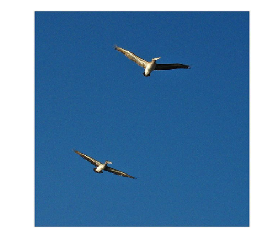

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

myimshow(train_set[0]['image'])

In [7]:
# class Yolo_detector(Yolov2):
#     def __init__(self):
#         super(Yolo_detector, self).__init__()
        
#     def criterion(self, y, d):
#         return loss.loss(y, d[0], d[1])

In [8]:
net = Yolov2()
net = build.load_pretrained_weights(net)
build.model_freeze_upto(net, 38)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

<generator object Module.children at 0x7fb6f90be6d0>
conv20.weight torch.Size([1024, 1024, 3, 3]) True
batchnorm20.weight torch.Size([1024]) True
batchnorm20.bias torch.Size([1024]) True
conv21.weight torch.Size([1024, 3072, 3, 3]) True
batchnorm21.weight torch.Size([1024]) True
batchnorm21.bias torch.Size([1024]) True
conv22.weight torch.Size([125, 1024, 1, 1]) True
conv22.bias torch.Size([125]) True


In [9]:
class YOLOStatsManager(nt.StatsManager):
    def __init__(self):
        super(YOLOStatsManager, self).__init__()

    def init(self):
        super(YOLOStatsManager, self).init()
        #self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d): 
        super(YOLOStatsManager, self).accumulate(loss)
#         _, l = torch.max(y, 1)
#         self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(YOLOStatsManager, self).summarize() 
#         accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss}

In [10]:
!rm -r yolo_voc1

lr = 1e-3
# net = Yolo_detector()
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="yolo_voc1", 
                     batch_size = batch_size, perform_validation_during_training=False)

Start/Continue training from epoch 0


KeyError: 'iteration'

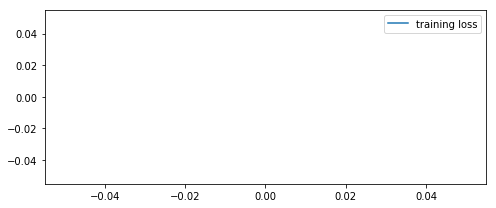

In [11]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(exp.epoch)], label="training loss")
    plt.tight_layout()
    fig.canvas.draw()
    axes.legend()

fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))